In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score,mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.tsa.seasonal import MSTL
import itertools

### Load data

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Postgres and Snowflake") \
    .config("spark.jars.packages",
            "net.snowflake:spark-snowflake_2.12:2.11.0-spark_3.3,"
            "net.snowflake:snowflake-jdbc:3.13.22") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/hadoop/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
net.snowflake#spark-snowflake_2.12 added as a dependency
net.snowflake#snowflake-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b61fb2c8-a7e0-4df3-a0a0-11b8c08506d0;1.0
	confs: [default]
	found net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 in central
	found net.snowflake#snowflake-ingest-sdk;0.10.8 in central
	found net.snowflake#snowflake-jdbc;3.13.22 in central
:: resolution report :: resolve 143ms :: artifacts dl 12ms
	:: modules in use:
	net.snowflake#snowflake-ingest-sdk;0.10.8 from central in [default]
	net.snowflake#snowflake-jdbc;3.13.22 from central in [default]
	net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|

In [4]:
from dotenv import load_dotenv
import os

dotenv_path = os.path.abspath("../../spark/.env")
load_dotenv(dotenv_path=dotenv_path)
#snowflake conector config
sfOptions = {
    "sfURL": os.getenv("SF_URL"),
    "sfUser": os.getenv("SF_USER"),
    "sfPassword": os.getenv("SF_PASSWORD"),
    "sfDatabase": os.getenv("SF_DATABASE"),
    "sfSchema": os.getenv("SF_SCHEMA"),
    "sfWarehouse": os.getenv("SF_WAREHOUSE"),
    "sfRole": os.getenv("SF_ROLE"),
    "insecureMode": "true"
}

In [5]:
df = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.MONTHLY_REVENUE_PROFIT") \
    .load()

df.show()

25/06/04 15:40:25 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+------------------+
|     MONTH|       TOTAL_REVENUE|      TOTAL_PROFIT|
+----------+--------------------+------------------+
|2016-07-31|        6.25174137E7|     1.151157555E7|
|2016-08-31|5.8620393089999996E7|     1.096006947E7|
|2016-09-30|       3.700957113E7|        6947049.62|
|2016-10-31|2.9358311220000003E7| 5640555.550000001|
|2016-11-30|       2.033400915E7|        3893238.64|
|2016-12-31|2.3209091009999998E7|        4581453.17|
|2017-01-31|         2.0726811E7|        3762316.39|
|2017-02-28|2.6263589939999998E7|        4782356.24|
|2017-03-31|       3.335273298E7| 6050520.890000001|
|2017-04-30|       4.554365382E7| 8101091.350000001|
|2017-05-31|       4.262598648E7|        7793814.24|
|2017-06-30|       4.126022334E7|        7280303.82|
|2017-07-31|       3.377494701E7|        6239033.47|
|2017-08-31|       4.266063396E7|8086754.5200000005|
|2017-09-30|       2.637974682E7| 4845988.720000001|
|2017-10-31|       2.139435648E7|3846817.36000

In [6]:
df = df.toPandas()
df.head()

,MONTH,TOTAL_REVENUE,TOTAL_PROFIT
0,2016-07-31,62517413.70,11511575.55
1,2016-08-31,58620393.09,10960069.47
2,2016-09-30,37009571.13,6947049.62
3,2016-10-31,29358311.22,5640555.55
4,2016-11-30,20334009.15,3893238.64


In [7]:
df.set_index('MONTH', inplace=True)
df.index = pd.to_datetime(df.index)

In [8]:
train = df[(df.index >= '2017-01-01') & (df.index < '2021-01-01')]
test = df[df.index >= '2021-01-01']

#### MSTL

In [9]:
mstl = MSTL(train['TOTAL_REVENUE'].interpolate(method="linear"), periods=(6, 12))
res = mstl.fit()

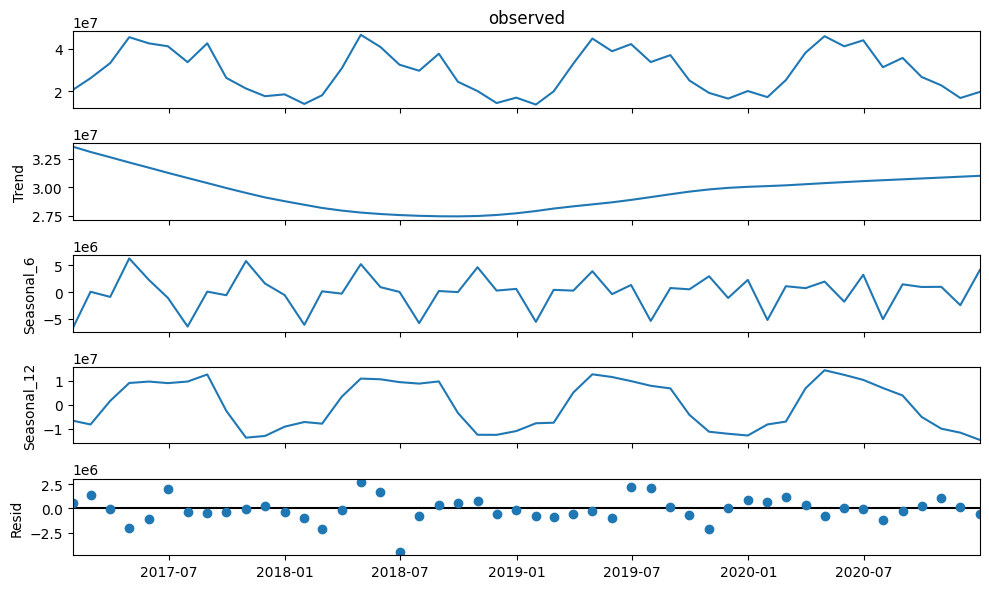

In [10]:
fig = res.plot()
fig.set_size_inches(10,6)
plt.tight_layout()
plt.show()

In [11]:
result = adfuller(res.resid)

# Trích xuất kết quả kiểm tra
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# In kết quả
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print('Critical Values:')
for key, value in critical_values.items():
    print(f'   {key}: {value}')


ADF Statistic: -7.550929007710268
p-value: 3.1904089585536414e-11
Critical Values:
   1%: -3.5812576580093696
   5%: -2.9267849124681518
   10%: -2.6015409829867675


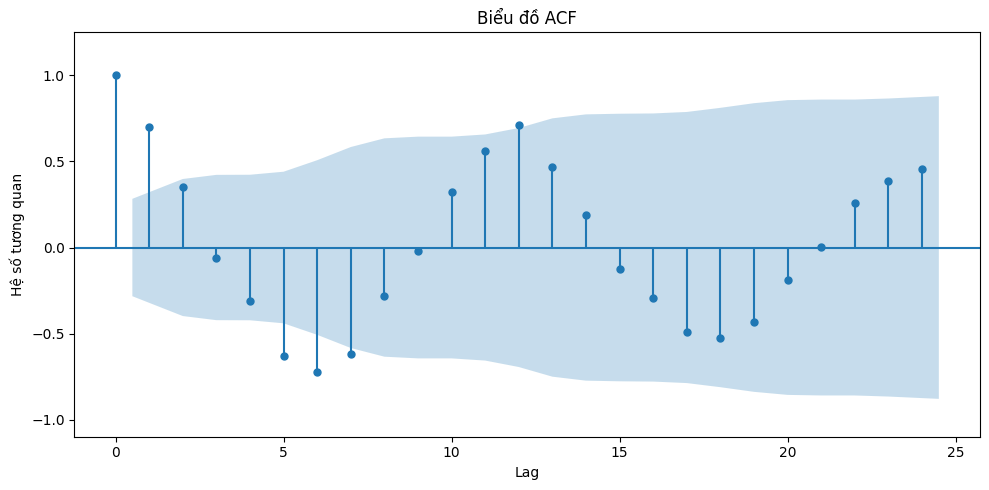

In [13]:
# plot acf of detrended time series
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(x=train["TOTAL_REVENUE"].dropna(), lags=24, ax=ax, alpha=0.05, auto_ylims=True)
ax.set_title("Biểu đồ ACF")
ax.set_ylabel("Hệ số tương quan")
ax.set_xlabel("Lag")
plt.tight_layout()

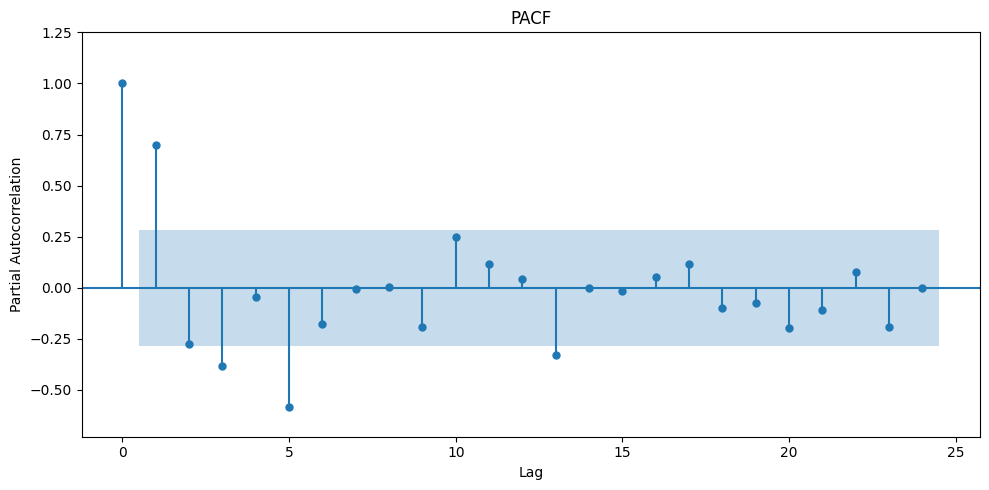

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(x=train["TOTAL_REVENUE"].dropna(), lags=24, ax=ax, alpha=0.05, auto_ylims=True)
ax.set_title("PACF")
ax.set_ylabel("Partial Autocorrelation")
ax.set_xlabel("Lag")
plt.tight_layout()

In [15]:
def select_best_arima(train, test, max_p=15, max_q=15):
    adf_result = adfuller(train)
    d = 0 if adf_result[1] < 0.05 else 1  
    
    # Danh sách các cặp (p, q) để thử
    pq_combinations = list(itertools.product(range(max_p+1), range(max_q+1)))
    
    best_rmse = np.inf
    best_order = None

    for p, q in pq_combinations:
        try:
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            #test
            y_pred = result.forecast(steps=len(test))
            
            # Tính RMSE
            rmse = root_mean_squared_error(test, y_pred)
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = (p, d, q)
        
        except Exception as e:
            continue  

    return best_order, best_rmse

In [16]:
def evaluate_model(y_preds, y_true):
    return {
        'R2 score': r2_score(y_true=y_true, y_pred=y_preds),
        'MAPE': mean_absolute_percentage_error(y_true=y_true, y_pred=y_preds),
        'RMSE': root_mean_squared_error(y_true=y_true, y_pred=y_preds)
    }

In [17]:
def arima(train, test, col_name = 'Revenue'):
    best_oder, _ = select_best_arima(train[col_name], test[col_name])
    model = ARIMA(train[col_name], order=best_oder)
    result = model.fit()
    y_test_pred = result.forecast(steps=len(test))
    y_train_pred = result.predict()
    # plt.figure(figsize=(15, 5))
    # plt.plot(test[col_name], label='Actual')
    # plt.plot(y_test_pred, label='Predicted')
    # plt.title(f'ARIMA model - {col_name}')
    # plt.legend()
    # plt.xticks(rotation=90)
    # plt.show()

    return y_train_pred, y_test_pred
    

### Revenue Prediction

In [18]:
revenue_train_pred, revenue_test_pred = arima(train, test, 'TOTAL_REVENUE')

/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, fr

In [19]:
evaluate_model(revenue_test_pred, test['TOTAL_REVENUE'])

{'R2 score': 0.8620912214848586,
 'MAPE': 0.11294843861383498,
 'RMSE': 3997328.071880999}

In [20]:
train['Revenue_pred'] = revenue_train_pred  
test['Revenue_pred'] = revenue_test_pred

/tmp/ipykernel_7003/2886237758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Revenue_pred'] = revenue_train_pred
/tmp/ipykernel_7003/2886237758.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Revenue_pred'] = revenue_test_pred


### Profit Prediction

In [21]:
profit_train_pred, profit_test_pred = arima(train, test, 'TOTAL_PROFIT')

/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/home/hadoop/FORECASTING BUSINESS PERFORMANCE/scripts/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, fr

In [22]:
evaluate_model(profit_test_pred, test['TOTAL_PROFIT'])

{'R2 score': 0.8973264171721101,
 'MAPE': 0.10497340805616318,
 'RMSE': 518674.72013502516}

In [23]:
train['Profit_pred'] = profit_train_pred
test['Profit_pred'] = profit_test_pred

/tmp/ipykernel_7003/1557144430.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Profit_pred'] = profit_train_pred
/tmp/ipykernel_7003/1557144430.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Profit_pred'] = profit_test_pred
